Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

In [2]:
import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import time
import voi_methods as vm
%matplotlib inline

In [3]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()

# Generate data

In [ ]:
drm.dcm2npy_batch()

In [ ]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [ ]:
vm.xref_dirs_with_excel()

In [ ]:
drm.load_patient_info(overwrite=False)

In [ ]:
drm.report_missing_folders()

In [ ]:
drm.load_vois_batch(cls=None, overwrite=False)

In [ ]:
vm.extract_vois()

In [ ]:
vm.reload_accnum('hcc', ['E105464882'], augment=True, overwrite=True)

In [ ]:
vm.save_unaugment_set()
vm.save_vois_as_imgs()

In [ ]:
vm.parallel_augment(num_cores=3, overwrite=100)

In [ ]:
voi_df_art[voi_df_art['id'].str.contains('4340_0')]

# Plotting

In [ ]:
voi_df_art[voi_df_art["acc_num"] == "12857716"]

-0.009371571 255.0 8.3655


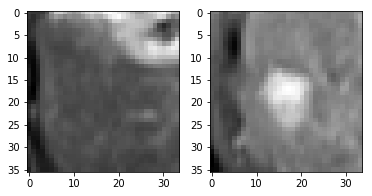

In [48]:
# can be used to determine if an image is flipped
cls = "hcc"
acc_num = 'E103224933'
img = np.load(C.full_img_dir+"\\"+cls + "\\"+acc_num + ".npy")
hf.plot_slice_flips(img, voi_df_art[(voi_df_art["acc_num"] == acc_num) & (voi_df_art["cls"] == cls)].iloc[0], flipz="both", pad=10)
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

-0.793521396124 0.920120736711 0.0242089069637


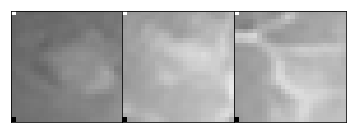

In [13]:
# Cropped, rescaled or augmented imgs
img = drm.plot_check(3, "E105464882_0", normalize=[-.8,.5])
print(np.amin(img), np.amax(img), np.mean(img))

In [46]:
vm.save_vois_as_imgs("hemangioma", save_dir="E:\\everything-small")

In [274]:
for x in voi_df_art["id"].values:
    vm.plot_multich_with_bbox(x+".npy", save_dir="E:\\everything-small")

C:\Users\Clinton\AppData\Local\conda\conda\envs\medical-env\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [56]:
vm.save_imgs_with_bbox(save_dir="E:\\everything")

C:\Users\Clinton\AppData\Local\conda\conda\envs\medical-env\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Generate reader study samples

In [24]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [68]:
voi_df_art = pd.read_csv("..\\data\\voi_art.csv")

In [69]:
Z_reader = ['12888679_2.npy', 'E101218384_5.npy', '12324408_0.npy', '12975280_0.npy', 'E100962970_0.npy', 'E101083458_1.npy', 'E105311123_0.npy', 'E104697262_0.npy', 'E100183257_1.npy', 'E103312835_1.npy', '13203550_7.npy', '12207268_0.npy', 'E100610622_0.npy', 'E100718398_0.npy', '12302576_0.npy', '12207268_2.npy', '12530153_0.npy', '13028374_0.npy', '12451831_0.npy', '12569826_0.npy', '12678910_1.npy', '12239783_0.npy', '12842070_0.npy', '12799652_0.npy', '12678910_0.npy', '12823036_0.npy', '11907521_0.npy', 'E100168661_0.npy', '12874178_3.npy', '12788616_0.npy', 'E102093118_0.npy', 'E105310461_0.npy', 'E103200384_1.npy', 'E102634440_0.npy', '12569915_0.npy', 'E102095465_0.npy', 'E102929168_0.npy', 'E102613189_0.npy', 'E103020139_1.npy', '12582632_0.npy', 'E100894274_0.npy', 'E100407633_0.npy', 'E101069048_1.npy', 'E101225606_0.npy', '13031955_0.npy', '12783467_0.npy', '13092966_0.npy', 'E105344747_0.npy', 'E100199185_0.npy', 'E106096969_0.npy', '12362250_5.npy', 'E100192709_1.npy', 'E105244287_0.npy', 'E106182827_0.npy', '13092836_2.npy', '12362250_4.npy', 'E104853578_1.npy', 'E100215900_8.npy', 'E102677567_0.npy', 'E100383453_0.npy']
Z_reader = [z[:-4] for z in Z_reader]

In [78]:
voi_reader = voi_df_art[voi_df_art["id"].isin(Z_reader)]#voi_df_art[voi_df_art.index.isin(Z_reader)]

In [71]:
f_map = {}
b_map = {}

In [79]:
for cls in C.classes_to_include:
    for index, row in voi_reader[voi_reader['cls'] == cls].iterrows():
        img_id = str(sum([row["x1"], row["x2"], row["y1"], row["y2"]])*10+row["z1"])
        acc_num = row["Filename"][:-4] #row["acc_num"]
        f_map[acc_num] = img_id
        b_map[img_id] = acc_num
        if img_id == "4613":
            print("Z:\\" + cls + "\\" + acc_num, 
                  row["x1"], row["x2"], row["y1"], row["z1"], "---",img_id)

Z:\hcc\E100199185 100 115 112 63 --- 4613
Z:\hemangioma\12678910 99 114 113 53 --- 4613


In [61]:
f_map['E100199185'] = '46130'
b_map['4613'] = "12678910"
b_map['46130'] = "E100199185"

In [110]:
multi_accnums = [accnum for accnum, count in zip(*np.unique(list(b_map.values()), return_counts=True)) if count>1]

In [117]:
for accnum in multi_accnums:
    f_map[accnum] = '-'.join([k for k in b_map if b_map[k] == accnum])
    #print(accnum, '-'.join([k for k in b_map if b_map[k] == accnum]))

In [140]:
for _, row in voi_reader[["Filename", "cls"]].iterrows():
    acc_num, cls = row
    acc_num = str(acc_num)[:-4]
    for protocol in ["T1_AP", "T1_VP", "T1_EQ"]:
        try:
            target_dir = os.path.join("Z:\\Inter-reader study\\DICOMs", f_map[acc_num], protocol)
            shutil.copytree(os.path.join("Z:", cls, acc_num, protocol), target_dir)
        except:
            pass

In [121]:
for acc_num in f_map:
    try:
        os.rename(os.path.join("Z:\\Inter-reader study\\DICOMs", acc_num),
                  os.path.join("Z:\\Inter-reader study\\DICOMs", f_map[acc_num]))
    except Exception as e:
        print(acc_num, e)

E100718398 [WinError 2] The system cannot find the file specified: 'Z:\\Inter-reader study\\DICOMs\\E100718398' -> 'Z:\\Inter-reader study\\DICOMs\\4968'
13092836 [WinError 2] The system cannot find the file specified: 'Z:\\Inter-reader study\\DICOMs\\13092836' -> 'Z:\\Inter-reader study\\DICOMs\\3676'


# Read Run Stats

In [52]:
import re
import operator

df = pd.read_csv(C.run_stats_path)

df = df.dropna(subset=['misclassified_test'])
df = df.loc[:,['misclassified_test','misclassified_train']]
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['misclassified_train'].values
#mis_test = df['misclassified_test'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_x

In [14]:
df = pd.read_csv(C.run_stats_path)
df = df[(df['test_num'] == 10) & (~df['time_dist']) & (df['steps_per_epoch'] == 750) & (df['timestamp'] > 1515210355)]

In [21]:
train_acc = [1-x.count("npy")/434 for x in df['misclassified_train'].values]

In [27]:
np.mean(train_acc)

0.9958525345622119

In [112]:
cms = df['confusion_matrix'].values

cms = ''.join(cms)

ret = hf.str_to_lists(cms, dtype=int)

supercm = ret

supercm = [supercm[rownum:rownum+6] for rownum in range(0,len(supercm),6)]

supercm = np.array(supercm)

cm_sum = np.empty((6,6))

for i in range(6):
    for j in range(6):
        cm_sum[i,j] = np.sum(supercm[:,i,j])

for i in range(6):
    for j in range(6):
        print(cm_sum[j,i],end='\t')
    print()

187.0	4.0	1.0	0.0	0.0	11.0	
1.0	180.0	18.0	0.0	10.0	6.0	
3.0	6.0	177.0	3.0	7.0	0.0	
0.0	0.0	1.0	197.0	2.0	0.0	
1.0	2.0	3.0	0.0	181.0	2.0	
8.0	8.0	0.0	0.0	0.0	181.0	


In [29]:
truths = df['y_true'].values
truths = ''.join(truths)
truths = hf.str_to_lists(truths, dtype=int)
truths = np.array(truths)

predictions = df['y_pred_raw'].values
predictions = ''.join(predictions)
predictions = hf.str_to_lists(predictions, dtype=float)
predictions = [predictions[rownum:rownum+60] for rownum in range(0,len(predictions),60)]
predictions = np.array(predictions)

hcc_thresh = []
nonhcc_thresh = []
thresh_dict = {}

for run_num in range(20):
    for lesion_num in range(60):
        if truths[run_num, lesion_num] == C.classes_to_include.index('hcc'):
            hcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'hcc'
        else:
            nonhcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'non-hcc'

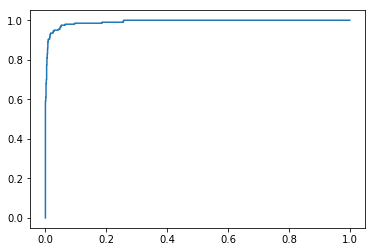

In [31]:
TPR = [200/200]
FPR = [1000/1000]

hcc_correct = 200
hcc_wrong = 1000
for key in sorted(thresh_dict):
    if thresh_dict[key] == 'hcc':
        hcc_correct -= 1
    else:
        hcc_wrong -= 1
    TPR.append(hcc_correct/200)
    FPR.append(hcc_wrong/1000)

plt.plot(FPR, TPR)

In [37]:
AUC = sum([(FPR[i]-FPR[i+1])*TPR[i] for i in range(len(FPR)-1)])
AUC

0.9922300000000035

a = run_stats.loc[:,['y_true','y_pred_raw']]
a = a.dropna()
b = a.iloc[0]['y_pred_raw']
b = hf.str_to_lists(b)